<a href="https://colab.research.google.com/github/Killua62612/OCR-data-collection/blob/main/Test_4_KP_(PDF_%26_Image)_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# TensorFlow
# !pip install python-doctr[tf]
# PyTorch

!pip install python-doctr[torch]

#Needed for exporting data

!pip install tabula-py
!pip install pandas

In [ ]:
# Colab related installations to install pyproject.toml projects correctly
!sudo apt install libcairo2-dev pkg-config
!pip3 install pycairo
# Install the most up-to-date version from GitHub
# TensorFlow
# !pip install python-doctr[tf]@git+https://github.com/mindee/doctr.git
# PyTorch
!pip3 install python-doctr[torch]@git+https://github.com/mindee/doctr.git


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libcairo2-dev is already the newest version (1.16.0-5ubuntu2).
pkg-config is already the newest version (0.29.2-1ubuntu3).
0 upgraded, 0 newly installed, 0 to remove and 18 not upgraded.
  Cloning https://github.com/mindee/doctr.git to /tmp/pip-install-s74rmatr/python-doctr_1e9da40fe5144ebfadc0e16beecbc4eb
  Running command git clone --filter=blob:none --quiet https://github.com/mindee/doctr.git /tmp/pip-install-s74rmatr/python-doctr_1e9da40fe5144ebfadc0e16beecbc4eb
  Resolved https://github.com/mindee/doctr.git to commit 28e5375c399ae5dd146a1b7e13bd5831acb6dc2d
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-freefont-ttf is already the newest version (20120503-10build1).
0 upgraded, 0 newly installed, 0 to remove and 18 not upgraded.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Saving United Utilities.pdf to United Utilities (2).pdf


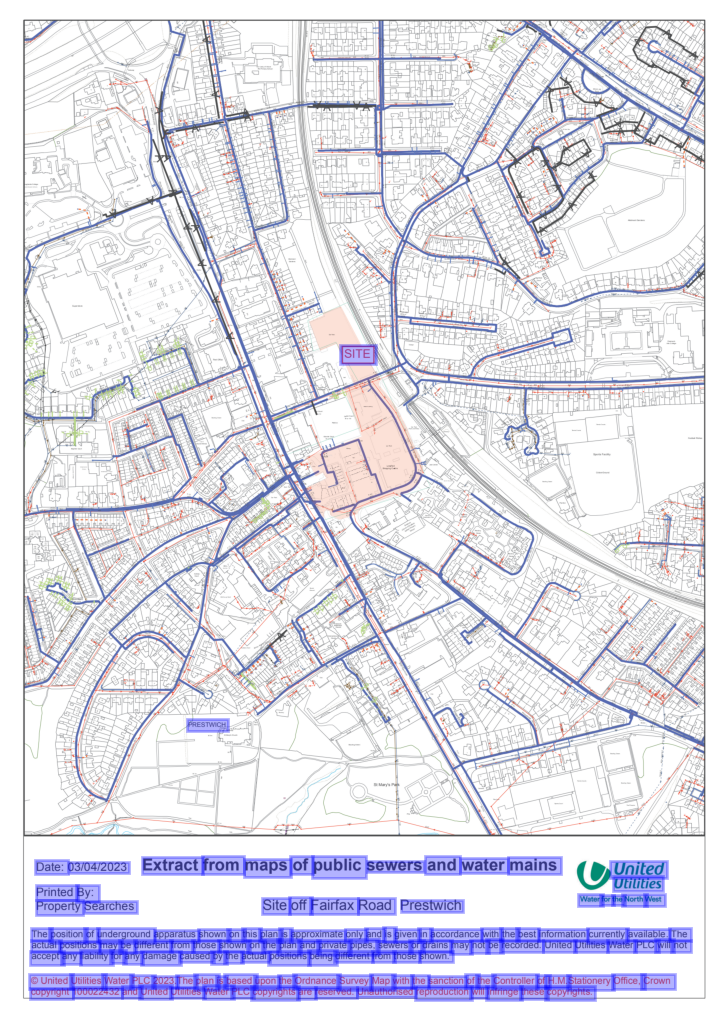

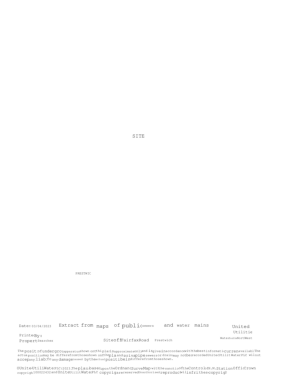

In [6]:
# Pre-requirement python PIP install
!sudo apt-get install fonts-freefont-ttf -y

from google.colab import drive
drive.mount('/content/drive')

%matplotlib inline
import os

# Let's pick the desired backend
os.environ['USE_TORCH'] = '1'

import matplotlib.pyplot as plt

from doctr.io import DocumentFile
from doctr.models import ocr_predictor
import pandas as pd
from PIL import Image
import io

# Uploads the PDF/Images into Colab
# Uncomment the import statement for file upload
from google.colab import files

# Upload the file to Colab
uploaded_files = files.upload()

# Get the uploaded file's name
file_name = list(uploaded_files.keys())[0]

# Determine the file type
if file_name.endswith(('.pdf')):
    file_type = 'pdf'
elif file_name.endswith(('.jpeg', '.jpg', '.png')):
    file_type = 'image'
else:
    print("Unsupported file type. Please upload a PDF or an image.")
    file_type = None

if file_type:
    # Initialize the OCR predictor model
    model = ocr_predictor(pretrained=True)

    if file_type == 'pdf':
        # Create a DocumentFile instance from the uploaded PDF
        doc = DocumentFile.from_pdf(file_name)
    else:
        # Convert image files to a PDF file
        pdf_filename = 'converted_images.pdf'
        images = [Image.open(io.BytesIO(uploaded_files[img_filename])) for img_filename in uploaded_files.keys()]
        images[0].save(pdf_filename, save_all=True, append_images=images[1:])

        # Create a DocumentFile instance from the converted PDF
        doc = DocumentFile.from_pdf(pdf_filename)

    # Analyze the document with OCR
    result = model(doc)

    # Create an empty list to store extracted text from each page
    extracted_text_list = []

    # Instantiate a pretrained model
    predictor = ocr_predictor(pretrained=True)

    # Print or use the extracted text as needed
    result = predictor(doc)

    result.show(doc)

    synthetic_pages = result.synthesize()
    plt.imshow(synthetic_pages[0])
    plt.axis('off')
    plt.show()


In [7]:
# Import necessary libraries
from PIL import Image
import numpy as np
from io import BytesIO
import pandas as pd

# Initialize the OCR predictor model
model = ocr_predictor(pretrained=True)

# Create empty lists to store the extracted numbers and words
numbers = []
words = []

# Analyze the entire document with OCR
doc_result = model(doc)

# Initialize variables to track the current word and area
current_word = ""
current_area = ""

# Iterate through the pages, blocks, lines, and words to extract text and areas
for page in doc_result.pages:
    for block in page.blocks:
        for line in block.lines:
            for word in line.words:
                current_value = word.value
                # Check if the word contains any digits (indicating numbers)
                if any(char.isdigit() for char in current_value):
                    current_area = current_value
                else:
                    current_word = current_value

                # If both word and area are available, append them to the respective lists
                if current_word and current_area:
                    numbers.append(current_area)
                    words.append(current_word)
                    current_word = ""
                    current_area = ""

# Create a DataFrame from the extracted data
df = pd.DataFrame({'Words': words, 'Numbers': numbers})

# Sort the DataFrame alphabetically by the "Word" column
df = df.sort_values(by='Words')

# Define the output Excel file name
excel_filename = 'output.xlsx'

# Export the DataFrame to an Excel file
df.to_excel(excel_filename, index=False)

# Download the Excel file
files.download(excel_filename)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>